In [1]:
import sys
import os
sys.path.append('../')

import numpy as np
from astropy.table import Table
from astroquery.gaia import Gaia

import matplotlib.pyplot as plt
from tqdm import tqdm
import lmfit

import WD_models

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

plt.style.use('stefan.mplstyle')

In [2]:
catalog = Table.read('data/elbadry.fits.gz')
catalog = catalog[catalog['binary_type'] == b'WDMS']

In [3]:
catalog

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [4]:
def wd_sep(bp_rp):
    return 3.25*bp_rp + 9.625

wd_obj = []
ms_obj = []
drop = []

for i in tqdm (range(len(catalog))):
    mg1 = wd_sep(catalog['bp_rp1'][i])
    mg2 = wd_sep(catalog['bp_rp2'][i])
    
    M1 = catalog['phot_g_mean_mag1'][i] + 5 * (np.log10(catalog['parallax1'][i] / 100))
    M2 = catalog['phot_g_mean_mag2'][i] + 5 * (np.log10(catalog['parallax2'][i] / 100))
    
    if M1 > mg1 and M2 < mg2:
        wd_obj.append(1)
        ms_obj.append(2)
    elif M2 > mg2 and M1 < mg1:
        wd_obj.append(2)
        ms_obj.append(1)
    else:
        drop.append(i)
               
catalog.remove_rows(drop)
catalog['wd_obj'] = wd_obj
catalog['ms_obj'] = ms_obj

100%|██████████████████████████████████████████████████████████████████████████| 22563/22563 [00:00<00:00, 60657.12it/s]


In [5]:
def separate(catalog, column, ms_obj, wd_obj, newname = ''):      
    mstemp_arr = [ catalog[str(column) + str(ms_obj[i])][i] for i in range(len(ms_obj)) ]
    wdtemp_arr = [ catalog[str(column) + str(wd_obj[i])][i] for i in range(len(wd_obj)) ]
    
    catalog['ms_' + str(column)] = mstemp_arr
    catalog['wd_' + str(column)] = wdtemp_arr
    return catalog

### ---

convert_cols = ['source_id', 'parallax', 'parallax_over_error', 'phot_g_mean_mag', 'phot_g_mean_flux',
                'phot_g_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'bp_rp', 'ra', 'ra_error', 'dec', 'dec_error', 'l', 'b']

for col in convert_cols:
    catalog = separate(catalog, col, ms_obj, wd_obj)
    
catalog['wd_m_g'] = catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['ms_m_g'] = catalog['ms_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100)

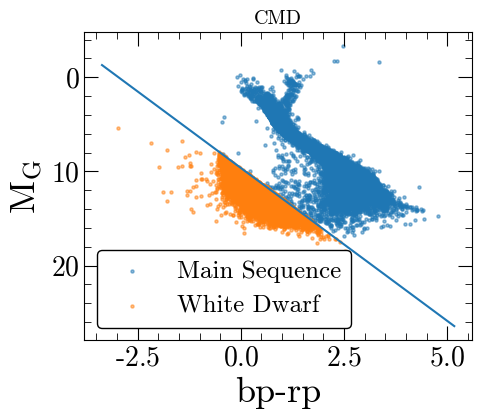

In [6]:
plt.figure(figsize=(5,4))

plt.scatter(catalog['ms_bp_rp'], catalog['ms_m_g'], label='Main Sequence', alpha = 0.5, s=5)
plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)

plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

#plt.savefig('plots/selection/wd_ms_cmd.png')

plt.legend()
plt.show()

In [7]:
ONe_model = WD_models.load_model('f', 'f', 'o', atm_type = 'H', HR_bands = ['bp-rp', 'G'])
CO_model = WD_models.load_model('f', 'f', 'f', atm_type = 'H', HR_bands = ['bp-rp', 'G'])

g_acc = (10**CO_model['logg'])/100
rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = CO_model['logg'], y = 10**CO_model['logteff'],
                                            z = rsun, interp_type = 'linear')

In [8]:
CO_model['HR_to_mass'](1,15)

array(0.75681863)

Text(0.5, 0, 'Interpolated WD Mass')

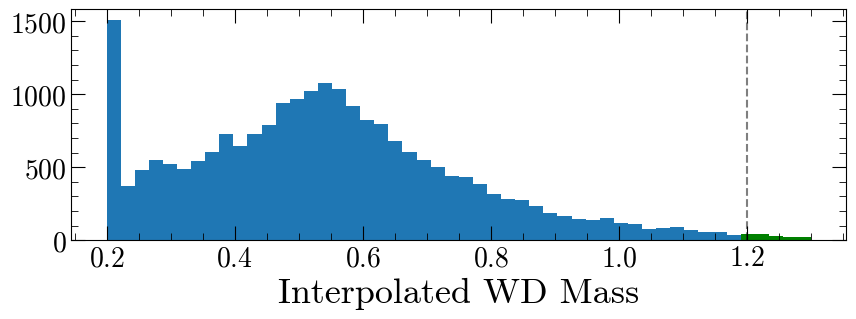

In [9]:
catalog['wd_mass'] = CO_model['HR_to_mass'](catalog['wd_bp_rp'], catalog['wd_m_g'])
catalog = catalog[~np.isnan(catalog['wd_mass'])]

cutoff = 1.2 # M_sun

highmass = catalog[catalog['wd_mass'] > cutoff]

f = plt.figure(figsize = (10, 3))
N, bins, patches = plt.hist(catalog['wd_mass'], bins = 50)
for ii, val in enumerate(bins):
    if val >= cutoff:
        point = ii-1
        break
for p in range(len(patches)):
    if p >= point:
        patches[p].set_facecolor('green')
plt.axvline(x = cutoff, c='k', ls = '--', alpha = 0.5)
plt.xlabel('Interpolated WD Mass')

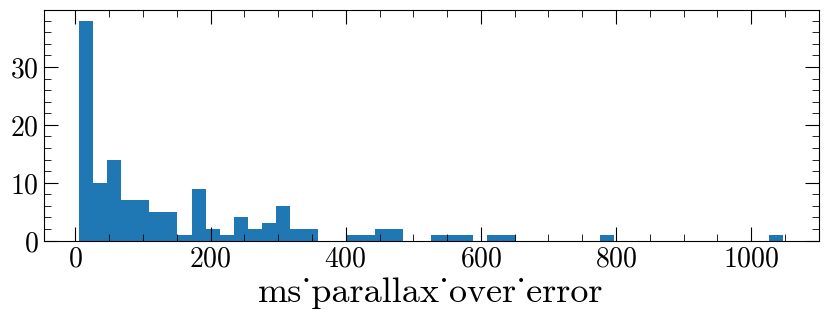

In [10]:
f, (ax1) = plt.subplots(1, 1, sharex=False, figsize = (10, 3))

N, bins, patches = ax1.hist(highmass['ms_parallax_over_error'], bins = 50)
ax1.set_xlabel('ms_parallax_over_error')

plt.show()

In [11]:
print(len(highmass))

131


In [12]:
from astropy.table import Table, vstack, hstack, unique, join

stardats = []
iters = (len(highmass)+100) // 100

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT dist.source_id as ms_source_id, dist.r_med_geo, (dist.r_hi_geo - dist.r_lo_geo) / 2 as e_r_med_go 
        FROM gaiadr3.gaia_source as gaia
        JOIN external.gaiaedr3_distance as dist
        ON gaia.source_id = dist.source_id      
        WHERE gaia.source_id in {}""".format(tuple(highmass['ms_source_id'][100*i:100*i+100]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
bjdist = vstack(stardats)
highmass = unique(join(highmass, bjdist, keys = 'ms_source_id'), keys = 'ms_source_id')

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.06s/it]


In [13]:
sigmaG_0 = 0.0027553202
sigmaGBP_0 = 0.0027901700
sigmaGRP_0 = 0.0037793818

highmass['e_wd_phot_g_mean_mag'] = np.sqrt((-2.5/np.log(10)*highmass['wd_phot_g_mean_flux_error']/highmass['wd_phot_g_mean_flux'])**2 + sigmaG_0**2)
highmass['e_wd_phot_bp_mean_mag'] = np.sqrt((-2.5/np.log(10)*highmass['wd_phot_bp_mean_flux_error']/highmass['wd_phot_bp_mean_flux'])**2 + sigmaGBP_0**2)
highmass['e_wd_phot_rp_mean_mag'] = np.sqrt((-2.5/np.log(10)*highmass['wd_phot_rp_mean_flux_error']/highmass['wd_phot_rp_mean_flux'])**2 + sigmaGRP_0**2)

In [14]:
print(min(highmass['e_wd_phot_rp_mean_mag']))

0.0045151673634274865


In [15]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['bp-rp', 'G'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed_gaia = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['bp', 'rp'])#, 'Si', 'Sz'])

initialized with atm_type = H and bands = ['bp', 'rp']


In [16]:
def mag_to_flux(mag):
    return 10 ** ((mag )/ -2.5) 

def flux_to_mag(flux):
    return -2.5 * np.log10(flux)
    
def get_model_flux_gaia(params):
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed_gaia.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux_to_mag(flux)
    

def residual_gaia(params, obs_flux = None, e_obs_flux = None):
    model_flux = (get_model_flux_gaia(params))
    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [17]:
def get_parameters_gaia(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):         
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual_gaia, params, kws = dict(obs_flux = obs_mag, e_obs_flux = e_obs_mag), method = 'least_squares')
    
    #result.params.pretty_print()
        
    return result

In [18]:
id_ = []

highmass['id'] = -999*np.ones(len(highmass))

highmass['radius'] = -999*np.ones(len(highmass))
highmass['e_radius'] = -999*np.ones(len(highmass))

highmass['teff'] = -999*np.ones(len(highmass))
highmass['e_teff'] = -999*np.ones(len(highmass))

highmass['logg'] = -999*np.ones(len(highmass))
highmass['e_logg'] = -999*np.ones(len(highmass))


for i in tqdm(range(len(highmass))):
    highmass['id'][i] = i
    
    obs_mag = np.array([highmass['wd_phot_bp_mean_mag'][i], highmass['wd_phot_rp_mean_mag'][i]])
    e_obs_mag = np.array([highmass['e_wd_phot_bp_mean_mag'][i], highmass['e_wd_phot_rp_mean_mag'][i]])
        
    params = get_parameters_gaia(obs_mag, e_obs_mag, vary_logg=False, p0 = [10000, 8, 0.001, highmass['r_med_geo'][i]])
    
    highmass['radius'][i] = params.params['radius'].value
    highmass['e_radius'][i] = params.params['radius'].stderr
    
    highmass['teff'][i] = params.params['teff'].value
    highmass['e_teff'][i] = params.params['teff'].stderr
    
    highmass['logg'][i] = params.params['logg'].value
    highmass['e_logg'][i] = params.params['logg'].stderr
    
    
    fig = plt.figure(figsize = (8,7))
    
    bands = ['bp', 'rp']#, 'i', 'z']

    plt.errorbar(bands, obs_mag, yerr = e_obs_mag,
                 linestyle = 'none', marker = 'None', color = 'k', capsize = 5, label = 'Observed SED')
    plt.plot(bands, get_model_flux_gaia(params.params), 'bo', markersize = 10, label = 'Model SED')
    
    plt.title('Radius: {} +/- {}'.format(highmass['radius'][i], highmass['e_radius'][i]))
    
    plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(params.params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.20, r'$logg = ${} '.format(params.params['logg'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.15, r'$dist = ${} $pc$'.format(params.params['distance'].value), transform = plt.gca().transAxes, fontsize=20)
    plt.text(0.15, 0.36, r'$bp-rp = ${}'.format(highmass['wd_bp_rp'][i]), transform = plt.gca().transAxes, fontsize=20)
    
    plt.xlabel('Band')
    plt.ylabel('Apparent Flux)')
    
    plt.gca().invert_yaxis()
    plt.legend() 
    
    plt.savefig('plots/radius-fits/radfit_{}.pdf'.format(i))
    plt.savefig('plots/radius-fits/radfit_{}.png'.format(i))
    
    plt.close()



100%|█████████████████████████████████████████████████████████████████████████████████| 131/131 [02:30<00:00,  1.15s/it]


In [19]:
np.median(highmass['e_radius'])

6.17355060074199e-07

In [20]:
highmass[0]

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [21]:
highmass.write('data/allradii.fits', overwrite = True)

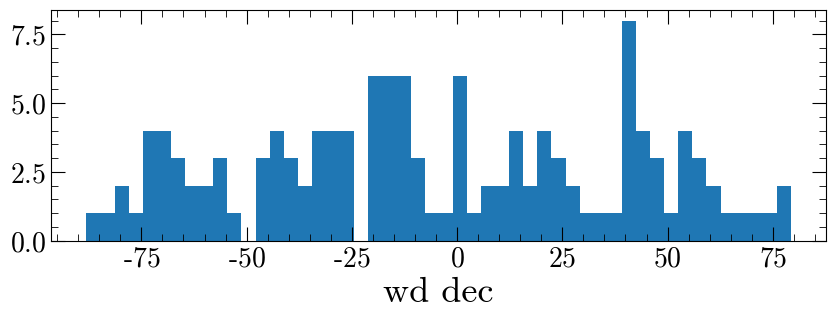

In [22]:
f, (ax1) = plt.subplots(1, 1, sharex=False, figsize = (10, 3))

N, bins, patches = ax1.hist(highmass['wd_dec'], bins = 50)
ax1.set_xlabel('wd dec')

plt.show()

In [34]:
southsky = highmass[highmass['wd_dec'] < -20]
southsky = southsky[southsky['ms_parallax_over_error'] > 100]
southsky = southsky[southsky['R_chance_align'] < 0.01]

In [35]:
print(len(southsky))

10


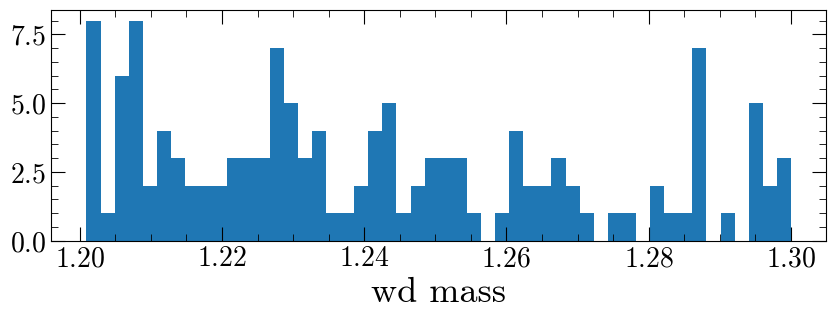

In [36]:
f, (ax1) = plt.subplots(1, 1, sharex=False, figsize = (10, 3))

N, bins, patches = ax1.hist(highmass['wd_mass'], bins = 50)
ax1.set_xlabel('wd mass')

plt.show()

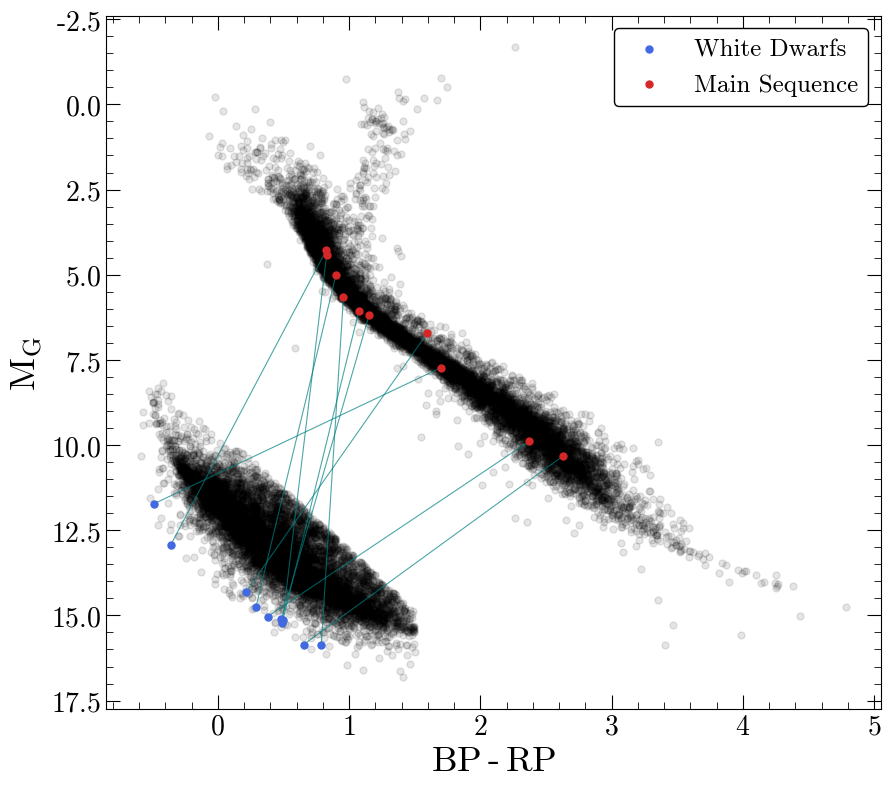

In [37]:
plt.figure(figsize=(10,9))

plt.scatter(catalog[catalog['ms_parallax_over_error'] > 100]['wd_bp_rp'], catalog[catalog['ms_parallax_over_error'] > 100]['wd_m_g'], c = 'k', alpha = 0.1)
plt.scatter(catalog[catalog['ms_parallax_over_error'] > 100]['ms_bp_rp'], catalog[catalog['ms_parallax_over_error'] > 100]['ms_m_g'], c = 'k', alpha = 0.1)

plt.scatter(southsky['wd_bp_rp'], southsky['wd_m_g'], c = 'royalblue', label='White Dwarfs', zorder = 2)
plt.scatter(southsky['ms_bp_rp'], southsky['ms_m_g'], c = 'C3', label='Main Sequence', zorder = 2)

for i in range(len(southsky)):
    plt.plot([southsky['wd_bp_rp'][i], southsky['ms_bp_rp'][i]], [southsky['wd_m_g'][i], southsky['ms_m_g'][i]], c = 'teal', alpha = 0.7, ls='-', lw = 0.8, zorder = 1)

plt.gca().invert_yaxis()

plt.ylabel(r'$M_G$')
plt.xlabel(r'$BP-RP$')

plt.legend()

Text(0.5, 0, 'MS Parallax Over Error')

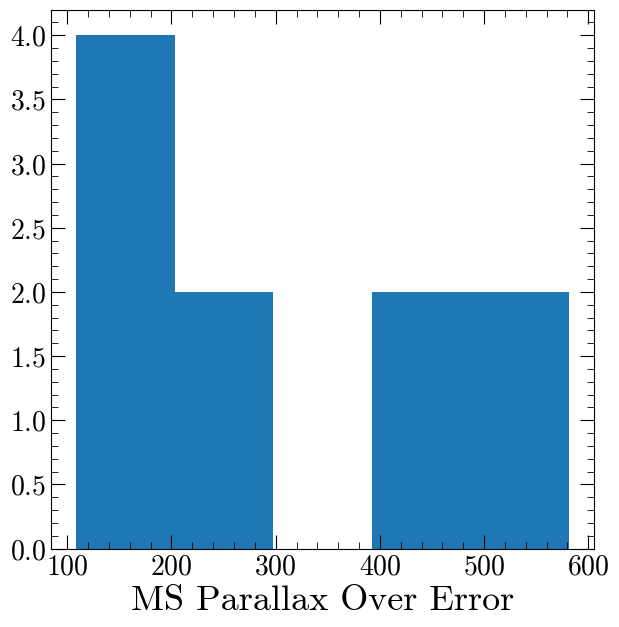

In [38]:
plt.hist(southsky['ms_parallax_over_error'])

plt.xlabel(r'MS Parallax Over Error')

Text(0.5, 0, 'Radius $[R_\\odot]$')

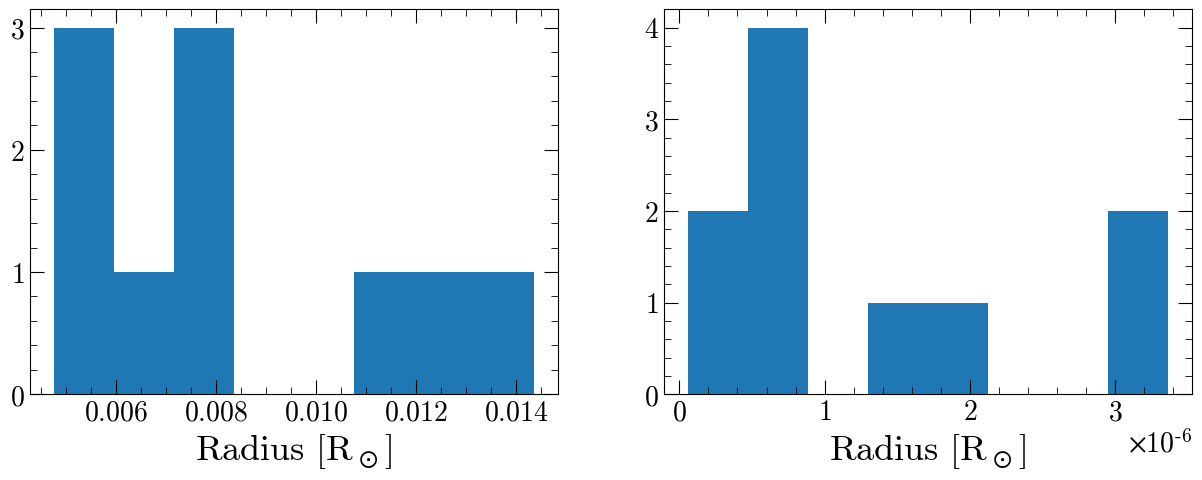

In [39]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1) 

plt.hist(southsky['radius'], bins = 8)

plt.xlabel(r'Radius $[R_\odot]$')

plt.subplot(1,2,2) 

#plt.xscale('log')
plt.hist(southsky['e_radius'], bins = 8)

plt.xlabel(r'Radius $[R_\odot]$')

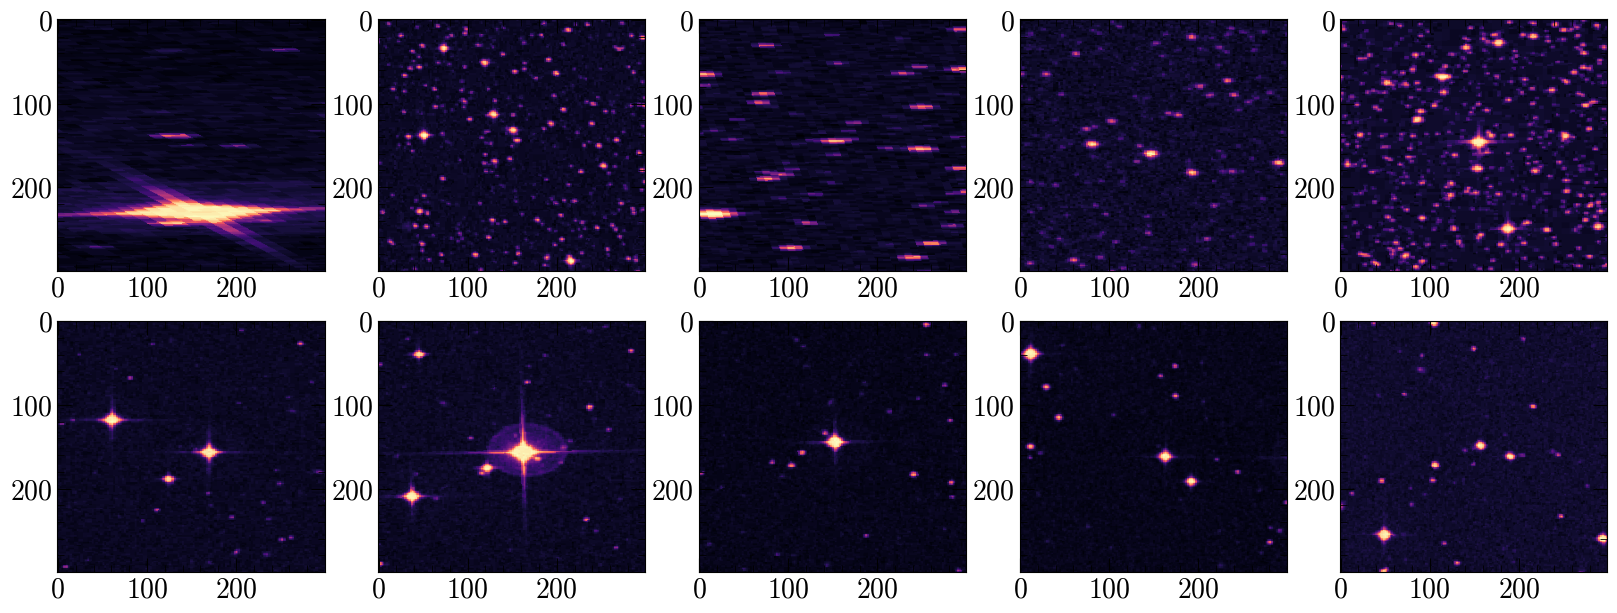

In [40]:
from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

coords = SkyCoord(ra = southsky['wd_ra'], dec = southsky['wd_dec'], unit = (u.deg, u.deg))

sv = SkyView()

fig = plt.figure(figsize = (20,15))

for i in range(len(coords)):
    test = sv.get_images(coords[i], survey='DSS', coordinates='ICRS', projection='Car', width = u.Quantity(5, unit=u.arcmin), height = u.Quantity(5, unit=u.arcmin), grid = True, gridlabels = True)

    plt.subplot(4,5,i+1)
    plt.imshow(test[0][0].data)
        

In [41]:
test[0][0].header

SIMPLE  =                    T / Written by SkyView Wed Aug 30 18:33:46 EDT 2023
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =                  0.0 / Fixed reference center                         
CRVAL2  =                  0.0 / Fixed reference center                         
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =                 2000 / ICRS coordinates                               
CTYPE1  = 'RA---CAR'           / Coordinates -- projection                      
CTYPE2  = 'DEC--CAR'           / Coordinates -- projection                      
CRPIX1  =  -149717.50000000006 / X reference pixel                              
CRPIX2  =    74579.420000000

In [42]:
southsky['wd_ra']

12.57290963508188
112.36642959780538
206.49862295133764
258.004079368927
232.13387792856875
349.9465758716682
352.16707430006767
332.86819167763247
338.1450258358862
318.3696327841368


In [44]:
southsky[['wd_source_id', 'ms_source_id', 'wd_ra', 'wd_dec', 'ms_ra', 'ms_dec', 'r_med_geo', 'R_chance_align', 'sep_AU', 'wd_phot_g_mean_mag', 'wd_phot_bp_mean_mag', 'wd_phot_rp_mean_mag', 'ms_phot_g_mean_mag', 'ms_phot_bp_mean_mag', 'ms_phot_rp_mean_mag']].write('./stars.csv')